# Training a Model
The purpose of this notebook is to train a lambeq model and then see how that model reacts to new data. The details of the aims are explained in **Entry 1** of [this journal page](/Journal/09_10_24.md). I will loosely be following [this example](https://cqcl.github.io/lambeq-docs/examples/quantum-pipeline.html) from lambeq's website.

In [12]:
### IMPORTS
import warnings
import os
from lambeq import BobcatParser, RemoveCupsRewriter

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

First, we read the input data.

In [17]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])  # Either 0 or 1 depending on whether about food or IT
            labels.append([t, 1-t])  # Converting to 2D array
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('data/training_data.txt')

Next, we create DisCoCat diagrams from the training data by using the `BobcatParser` object from the `lambeq` package.

In [18]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


**Optionally**, we can display the raw diagrams.

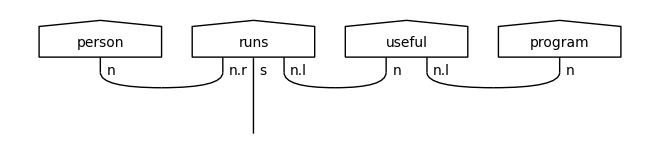

In [21]:
raw_train_diagrams[69].draw()

We now optimise the diagrams by removing the cups.